# Machine Learning Nanodegree
## Capstone Project: Electric Vehicle Detection 

# Introduction

### Setup

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display, Image 
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


# Pretty display for notebooks
%matplotlib inline

## Define Utiliy Functions

In [2]:
def pivot_raw_dataframe(df):
	pass

def add_implicit_temporal_dimensions(df):
	pass

def fill_missing_values(df):
	pass

def describe_houses(df):
	pass

def cluster_houses(df):
	pass

def select_best_k(df):
	pass

def transform_house_subset_to_time(df):
	pass

def augment_time_data(t_X, h_X, centers_df, k_col='k_9', diff_days=7):

	# day aggregation
	day_totals_df = t_X.groupby(['House ID','Day']).agg({'kWh':sum}).reset_index()
	day_totals_df.columns = ['House ID', 'Day', 'Day_kWh'] 

	# join
	t_X_aug = t_X.merge(day_totals_df, how='left', on=['House ID', 'Day'])
	t_X_aug = t_X_aug.merge(h_X[['House ID', k_col]], how='left', on='House ID')
	t_X_aug = t_X_aug.merge(centers_df, how='left', on='Half Hour')

	# scale up centers
	c_names = centers_df.columns.values.tolist()
	c_names.pop(0)

	t_X_aug[c_names] = t_X_aug[c_names].multiply(t_X_aug['Day_kWh'], axis='index')

	# calculate day difference
	for d in np.arange(1,diff_days+1):
		day_diff_col_name = "{}d_diff".format(d)
		t_X_aug[day_diff_col_name] = t_X_aug.groupby(['House ID','Half Hour'])['kWh'].diff(periods=d)

	# fill na to run model
	t_X_aug.fillna(value=0, inplace=True)

	return t_X_aug


def show_baseline_f1_scores(y):

	import math

	zero_zero = np.tile([0,0],math.floor(len(y)/2))
	if len(zero_zero) < len(y):
		zero_zero.append(0)
	
	zero_one = np.tile([0,1],math.floor(len(y)/2))
	if len(zero_zero) < len(y):
		zero_zero.append(0)
	
	one_one = np.tile([1,1],math.floor(len(y)/2))
	if len(zero_zero) < len(y):
		zero_zero.append(1)

	print ("All 0 F-score: {0:.3f}".format(f1_score(y, zero_zero)))
	print ("Alternating 0,1 F-score: {0:.3f}".format(f1_score(y, zero_one)))
	print ("All 1 F-score: {0:.3f}".format(f1_score(y, one_one)))


def format_EV_predictions(y, X, first_int=1, final_int=2880):

	preds_long = X[['House ID', 'Interval']].copy()

	preds_long['Label'] = y

	preds = preds_long.pivot(index='House ID',columns='Interval')

	preds.columns = preds.columns.get_level_values(0)

	preds.columns = ["Interval_{}".format(i) for i in np.arange(first_int, final_int+1).tolist()]

	return preds


# Data Clean Up

### Import

In [3]:
ev_train_raw = pd.read_csv('EV_train.csv')
ev_train_labels_raw = pd.read_csv('EV_train_labels.csv')

In [4]:
print(ev_train_raw.shape)
print(ev_train_labels_raw.shape)
display(ev_train_raw.head())
display(ev_train_labels_raw.head())
print(ev_train_raw.isnull().values.any())  # Null values in training dataset?
print(ev_train_labels_raw.isnull().values.any())  #Null values in training labels?

(1590, 2881)
(1590, 2881)


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233000,0.351000,0.194000,0.292000,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304000,0.361000,0.342000,0.355000,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125000,0.088000,0.106000,0.094000,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113
3,11636092,2.088,2.075,2.121,2.098,2.046,2.081000,1.847000,0.420000,0.399000,...,0.620,0.487,0.563,0.419,0.379,0.359,0.347,0.325,0.330,0.340
4,11647239,1.416,1.250,1.270,1.258,1.239,1.753105,4.609256,4.619256,4.075151,...,1.596,1.667,1.569,1.664,1.580,1.635,1.568,1.565,1.575,1.571


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11633257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11651552,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11636092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11647239,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


True
False


### Quantify Missing Values

In [5]:
# Missing value frequency by interval
ev_train_raw.isnull().sum(axis=0)[ev_train_raw.isnull().sum(axis=0)>0].value_counts()

1    288
4     48
3     48
2     48
dtype: int64

In [6]:
# Missing value frequency by house
ev_train_raw.isnull().sum(axis=1)[ev_train_raw.isnull().sum(axis=1)>0].value_counts()

432    1
48     1
144    1
96     1
dtype: int64

### Add Temporal Dimensions

In [7]:
ev_train_pivot = ev_train_raw.copy()
ev_train_pivot = pd.wide_to_long(ev_train_pivot, stubnames='Interval_', i='House ID', j='kWh').reset_index()
ev_train_pivot.columns = ['House ID', 'Interval', 'kWh']
ev_train_pivot['Interval'] = pd.to_numeric(ev_train_pivot['Interval'], downcast='integer')
ev_train_pivot = ev_train_pivot.sort_values(['House ID', 'Interval']).reset_index(drop=True)

In [8]:
ev_train_labels_pivot = ev_train_labels_raw.copy()
ev_train_labels_pivot = pd.wide_to_long(ev_train_labels_pivot, stubnames='Interval_', i='House ID', j='label').reset_index()
ev_train_labels_pivot.columns = ['House ID', 'Interval', 'Label']
ev_train_labels_pivot['Interval'] = pd.to_numeric(ev_train_labels_pivot['Interval'], downcast='integer')
ev_train_labels_pivot = ev_train_labels_pivot.sort_values(['House ID', 'Interval']).reset_index(drop=True)

In [9]:
ev_train_pivot_label = pd.concat([ev_train_pivot, ev_train_labels_pivot['Label']], axis=1)

In [10]:
##Checking Label Concatenation (pd.merge was failing due to memory limits?)

import random

display(ev_train_pivot_label[ev_train_pivot_label['House ID']==11647239].head(9))

all_raw_house_ids  = ev_train_raw['House ID'].unique()

random_house_id = random.choice(all_raw_house_ids)
random_interval = random.randint(1,2880)


lcr1 = ev_train_pivot_label['House ID']==random_house_id
lcc1 = ev_train_pivot_label['Interval']==random_interval
display(ev_train_pivot_label[lcr1&lcc1])

lcr2 = ev_train_raw.index[ev_train_raw['House ID']==random_house_id].values[0]
raw_kwh = ev_train_raw.iloc[lcr2,random_interval]
raw_label = ev_train_labels_raw.iloc[lcr2,random_interval]

rand_dict = {
    "House ID": random_house_id,
    "Interval": random_interval,
    "kWh": raw_kwh,
    "Label": raw_label 
}
print(rand_dict)


,House ID,Interval,kWh,Label
3173760,11647239,1,1.416000,0
3173761,11647239,2,1.250000,0
3173762,11647239,3,1.270000,0
3173763,11647239,4,1.258000,0
3173764,11647239,5,1.239000,0
3173765,11647239,6,1.753105,1
3173766,11647239,7,4.609256,1
3173767,11647239,8,4.619256,1
3173768,11647239,9,4.075151,1


,House ID,Interval,kWh,Label
1537865,11637228,2826,1.017,0


{'House ID': 11637228, 'Interval': 2826, 'kWh': 1.0170000000000001, 'Label': 0}


In [11]:
ev_train_raw.iloc[lcr2,random_interval-1:random_interval+1]

Interval_2825    1.087
Interval_2826    1.017
Name: 20, dtype: float64

In [12]:
print(ev_train_pivot.shape)
print(2*24*60*1590)

temp_dim_dict = {
    "Day": np.tile(np.repeat(np.arange(1,61),48),1590),
    "Hour": np.tile(np.tile(np.repeat(np.arange(1,25),2),60),1590),
    "Half Hour": np.tile(np.tile(np.arange(1,49),60),1590)
}

temp_dim_df = pd.DataFrame.from_dict(temp_dim_dict)

(4579200, 3)
4579200


In [13]:
ev_train_piv_lab_tmp = pd.concat([ev_train_pivot_label, temp_dim_df], axis=1)
ev_train_piv_lab_tmp_cols = ['House ID','Day','Hour','Half Hour','Interval', 'kWh', 'Label']
ev_train_piv_lab_tmp = ev_train_piv_lab_tmp[ev_train_piv_lab_tmp_cols] 
ev_train_piv_lab_tmp.head()

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
0,11628280,1,1,1,1,1.114,0
1,11628280,1,1,2,2,0.845,0
2,11628280,1,2,3,3,0.463,0
3,11628280,1,2,4,4,0.453,0
4,11628280,1,3,5,5,0.610,0


In [14]:
# Checking Temporal Concatenation (pd.merge was failing due to memory limits?)

check_aggs =['max', 'min','mean','count']

check_dict = {
    'Day' : check_aggs, 
    'Hour': check_aggs,
    'Half Hour': check_aggs,
}

temp_merge_check_df = ev_train_piv_lab_tmp.groupby('House ID').agg(check_dict)

unique_records = len(temp_merge_check_df.drop_duplicates())
total_records = len(temp_merge_check_df)

assert unique_records == 1, "Problem with temporal concatenation"

display(temp_merge_check_df.head())

Day                 Hour                 Half Hour                
         max min  mean count  max min  mean count       max min  mean count
House ID                                                                   
11628280  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628291  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628301  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628319  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880
11628335  60   1  30.5  2880   24   1  12.5  2880        48   1  24.5  2880

In [15]:
display(ev_train_piv_lab_tmp.iloc[45:50,])
display(ev_train_piv_lab_tmp[ev_train_piv_lab_tmp['House ID']==11647239].head(9))

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
45,11628280,1,23,46,46,1.146,0
46,11628280,1,24,47,47,1.130,0
47,11628280,1,24,48,48,1.170,0
48,11628280,2,1,1,49,1.239,0
49,11628280,2,1,2,50,0.952,0


,House ID,Day,Hour,Half Hour,Interval,kWh,Label
3173760,11647239,1,1,1,1,1.416000,0
3173761,11647239,1,1,2,2,1.250000,0
3173762,11647239,1,2,3,3,1.270000,0
3173763,11647239,1,2,4,4,1.258000,0
3173764,11647239,1,3,5,5,1.239000,0
3173765,11647239,1,3,6,6,1.753105,1
3173766,11647239,1,4,7,7,4.609256,1
3173767,11647239,1,4,8,8,4.619256,1
3173768,11647239,1,5,9,9,4.075151,1


### Fill in Missing Values

In [16]:
all_missing_rows = ev_train_piv_lab_tmp['kWh'].isnull()
display(ev_train_piv_lab_tmp[all_missing_rows].head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
757296,11632700,58,1,1,2737,NaN,0
757297,11632700,58,1,2,2738,NaN,0
757298,11632700,58,2,3,2739,NaN,0
757299,11632700,58,2,4,2740,NaN,0
757300,11632700,58,3,5,2741,NaN,0


In [17]:
house_hh_mean_df = ev_train_piv_lab_tmp.groupby(['House ID','Half Hour']).agg({'kWh':'mean'}).reset_index()

In [18]:
house_hh_mean_df.head()

,House ID,Half Hour,kWh
0,11628280,1,1.034950
1,11628280,2,0.990733
2,11628280,3,0.904383
3,11628280,4,0.940583
4,11628280,5,0.958350


In [19]:
ev_train_piv_lab_tmp_filled = ev_train_piv_lab_tmp.copy()

for idx, row in ev_train_piv_lab_tmp_filled[all_missing_rows].iterrows():

    missing_interval = row['Interval']
    missing_house = row['House ID']
    missing_half_hour = row['Half Hour']
    
    house_rm = house_hh_mean_df['House ID'] == missing_house
    half_hour_rm = house_hh_mean_df['Half Hour'] == missing_half_hour
    house_half_hour_average = house_hh_mean_df[house_rm&half_hour_rm]['kWh'].values[0]
    
    house_rf = ev_train_piv_lab_tmp_filled['House ID'] == missing_house
    interval_rf = ev_train_piv_lab_tmp_filled['Interval'] == missing_interval
    ev_train_piv_lab_tmp_filled['kWh'][house_rf&interval_rf] = house_half_hour_average

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
display(ev_train_piv_lab_tmp.iloc[757292:757299,:])
display(ev_train_piv_lab_tmp_filled.iloc[757292:757299,:])

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
757292,11632700,57,23,45,2733,1.812128,1
757293,11632700,57,23,46,2734,1.787128,1
757294,11632700,57,24,47,2735,1.242252,1
757295,11632700,57,24,48,2736,0.125000,0
757296,11632700,58,1,1,2737,NaN,0
757297,11632700,58,1,2,2738,NaN,0
757298,11632700,58,2,3,2739,NaN,0


,House ID,Day,Hour,Half Hour,Interval,kWh,Label
757292,11632700,57,23,45,2733,1.812128,1
757293,11632700,57,23,46,2734,1.787128,1
757294,11632700,57,24,47,2735,1.242252,1
757295,11632700,57,24,48,2736,0.125000,0
757296,11632700,58,1,1,2737,0.405968,0
757297,11632700,58,1,2,2738,0.413420,0
757298,11632700,58,2,3,2739,0.433921,0


In [21]:
print(ev_train_piv_lab_tmp_filled.shape)
print(sum(ev_train_piv_lab_tmp_filled['Label']))
print(sum(ev_train_piv_lab_tmp_filled['Label'])/ev_train_piv_lab_tmp_filled.shape[0])

(4579200, 7)
106910
0.0233468728162


# House Classification

### Transformation

In [22]:
house_data_summary = ev_train_piv_lab_tmp_filled.groupby(['House ID', 'Half Hour']
                                                ).agg({'kWh':['mean',np.std]}
                                                     ).pivot_table(values='kWh',
                                                                   index=['House ID'],
                                                                   columns='Half Hour').reset_index()

In [23]:
mean_cols = ['u_{}'.format(n) for n in np.arange(1,49)]
sd_cols = ['s_{}'.format(n) for n in np.arange(1,49)]
hds_cols = ['House ID'] + mean_cols + sd_cols
house_data_summary.columns = hds_cols

In [24]:
pct_cols = ['p_{}'.format(n) for n in np.arange(1,49)]
house_data_summary[pct_cols] = house_data_summary[mean_cols].div(house_data_summary[mean_cols].sum(axis=1),axis=0)

In [25]:
house_data_labels = ev_train_piv_lab_tmp_filled.groupby(['House ID']).agg({'Label':sum}).reset_index()
house_data_labels['House Label'] = [1 if x > 0 else 0 for x in house_data_labels['Label']]
house_data_labels.drop(['Label'], axis=1, inplace=True)
house_data_df = house_data_summary.merge(house_data_labels, how='left', on='House ID')

In [26]:
X_house = house_data_df.copy()
y_house = X_house['House Label']
X_house.drop(['House Label'], axis=1, inplace=True)
display(X_house.head())
display(y_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_39,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48
0,11628280,1.034950,0.990733,0.904383,0.940583,0.958350,0.940750,0.936317,0.919983,0.894133,...,0.021406,0.020981,0.019509,0.019009,0.019226,0.018909,0.019017,0.019521,0.019504,0.019241
1,11628291,0.742283,0.743917,0.742250,0.740300,0.743651,0.838403,0.771068,0.797265,0.762628,...,0.020703,0.018956,0.018786,0.018658,0.017564,0.017195,0.017451,0.018865,0.018214,0.017874
2,11628301,0.236132,0.273704,0.255804,0.248360,0.191183,0.202845,0.314648,0.314576,0.251421,...,0.063615,0.060917,0.055962,0.040179,0.025159,0.013686,0.010051,0.006760,0.006476,0.005591
3,11628319,0.779583,0.766733,0.660650,0.591733,0.600967,0.578200,0.581083,0.595033,0.615067,...,0.030123,0.035465,0.036182,0.035222,0.032022,0.030527,0.027833,0.024870,0.019554,0.017096
4,11628335,0.299017,0.301467,0.297050,0.286950,0.283717,0.293583,0.790850,0.914083,0.929167,...,0.037180,0.037238,0.021009,0.016897,0.015468,0.012938,0.011480,0.009744,0.008606,0.008468


0    0
1    1
2    1
3    0
4    0
Name: House Label, dtype: int64

### House Training split

In [27]:
from sklearn.model_selection import train_test_split

X_train_house, X_valid_house, y_train_house, y_valid_house = train_test_split(X_house,
                                                                            y_house,
                                                                            test_size=0.25,
                                                                            random_state=42)

### F1 Score for Houses

In [28]:
show_baseline_f1_scores(y_valid_house)

All 0 F-score: 0.000
Alternating 0,1 F-score: 0.367
All 1 F-score: 0.487


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### K-Means Clustering

In [29]:
k_values = np.arange(2,20)

centers_and_plot_dfs = []

for k in k_values:
    
    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(X_train_house[pct_cols].as_matrix())
    
    k_centers = kmeans_model.cluster_centers_
    
    k_col_name = "k_{}".format(k)
    
    X_train_house[k_col_name] = kmeans_model.labels_
    
    k_cols = pct_cols.copy()
    
    k_cols.insert(0, k_col_name)
    
    print(X_train_house[k_col_name].value_counts())
    
    k_cluster_mean_df = X_train_house.reset_index()[k_cols].groupby(k_col_name).mean()
    
    k_plot_df = k_cluster_mean_df.transpose()
    
    k_tuple = (k_centers, k_plot_df)
    
    centers_and_plot_dfs.append(k_tuple) 

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


1    910
0    282
Name: k_2, dtype: int64
0    650
2    343
1    199
Name: k_3, dtype: int64
0    415
2    363
1    286
3    128
Name: k_4, dtype: int64
4    362
0    330
3    243
2    133
1    124
Name: k_5, dtype: int64
1    366
4    292
0    208
3    143
5    103
2     80
Name: k_6, dtype: int64
5    353
0    227
1    161
2    151
3    133
4     97
6     70
Name: k_7, dtype: int64
1    342
2    214
6    140
3    140
0    114
5     87
7     80
4     75
Name: k_8, dtype: int64
5    285
2    209
4    185
3    154
0     95
1     93
8     83
6     55
7     33
Name: k_9, dtype: int64
6    247
2    195
3    143
1    135
8    129
5     96
4     84
9     61
0     56
7     46
Name: k_10, dtype: int64
3     243
1     184
8     136
5     129
10    112
2      89
9      88
0      81
7      68
4      32
6      30
Name: k_11, dtype: int64
3     239
9     184
8     148
2     131
4     103
10     87
0      80
1      69
7      64
6      37
5      29
11     21
Name: k_12, dtype: int64
5     245
4     1

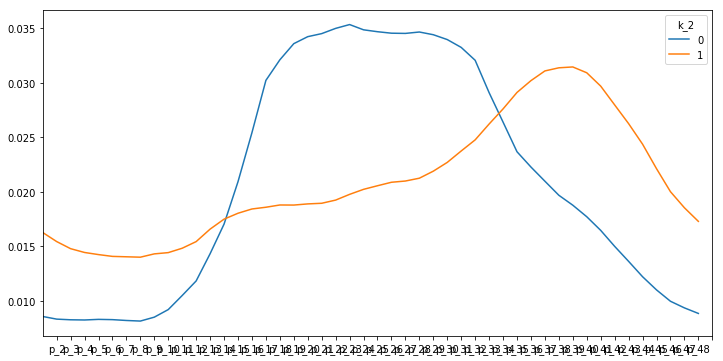

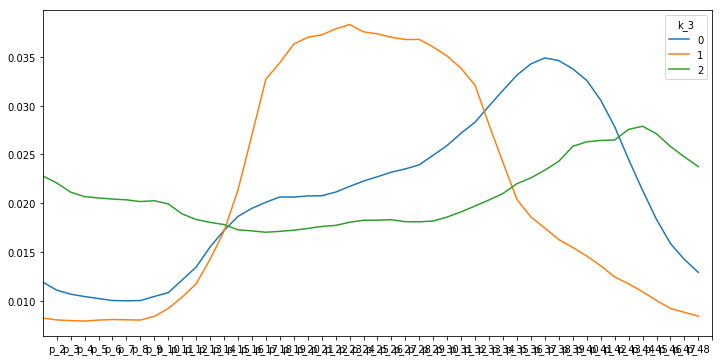

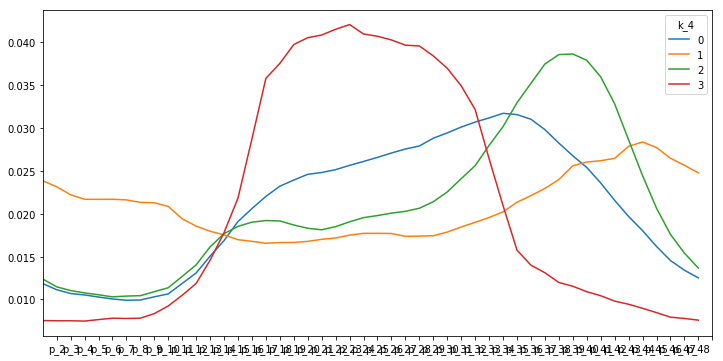

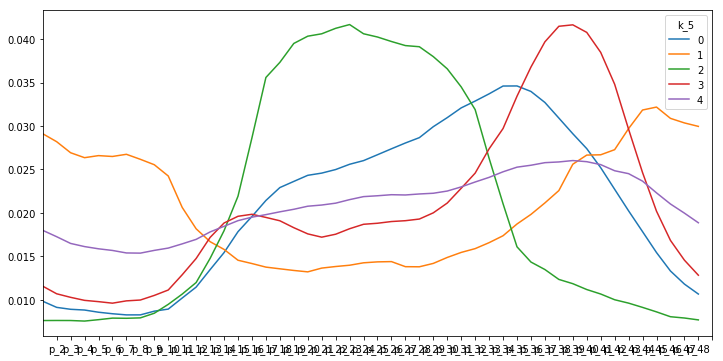

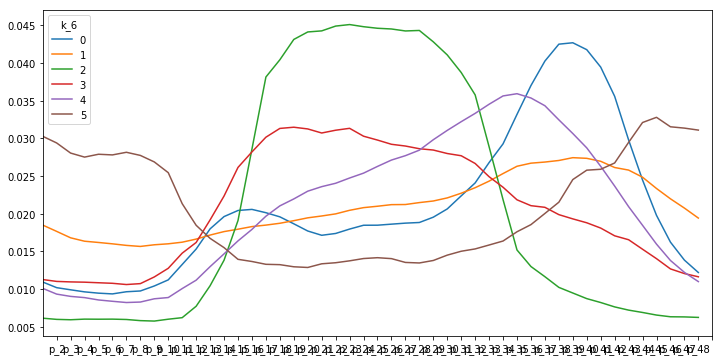

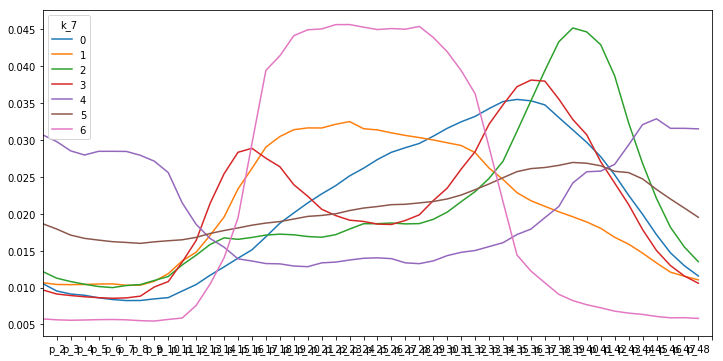

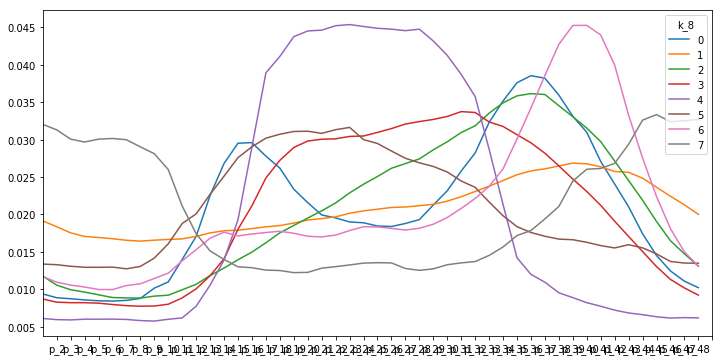

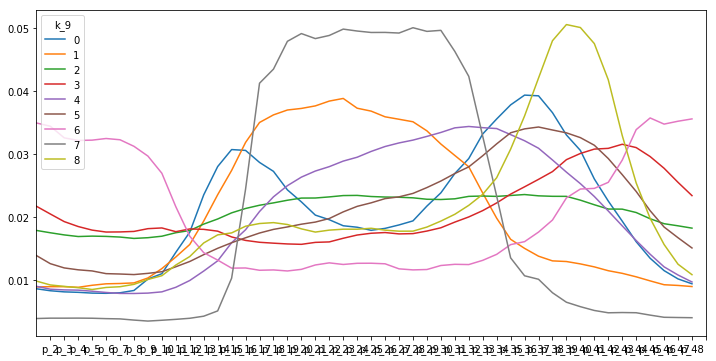

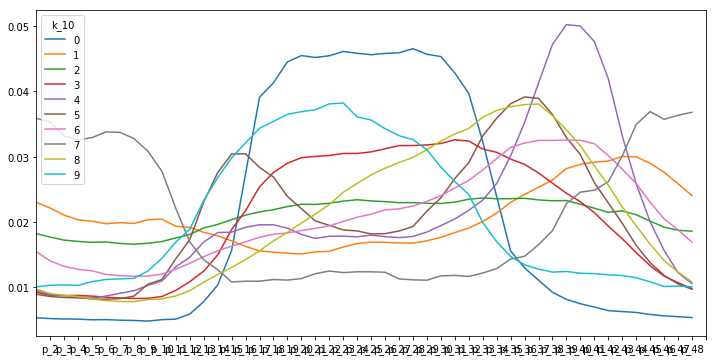

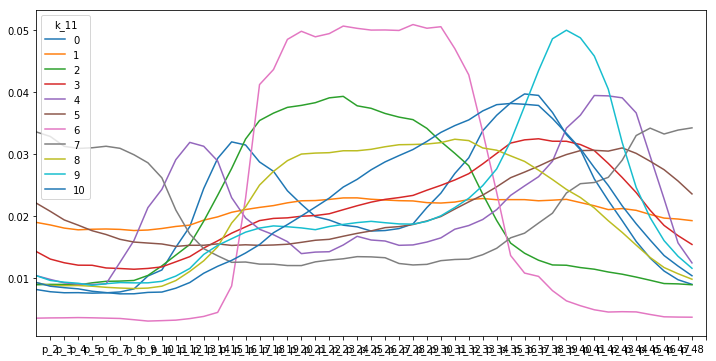

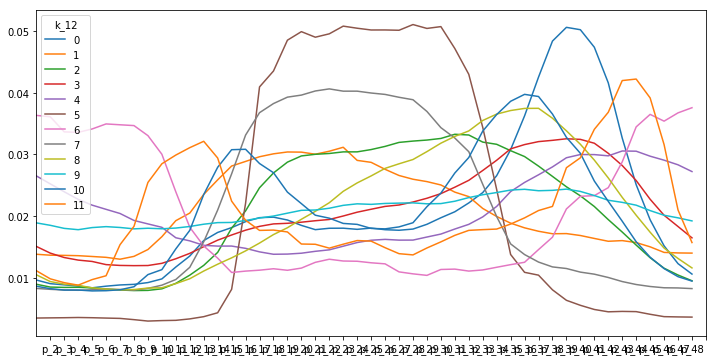

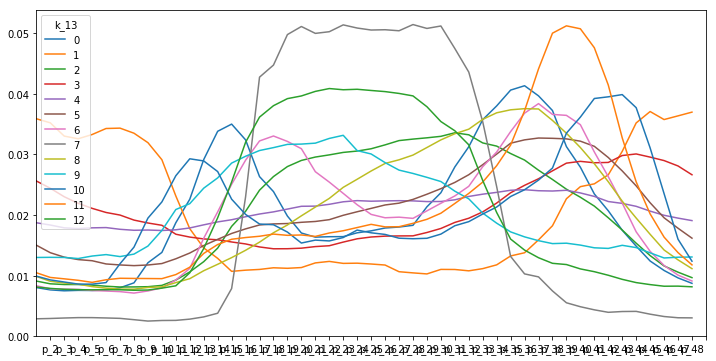

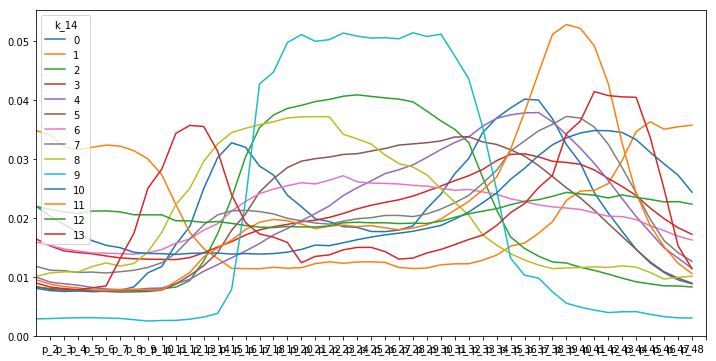

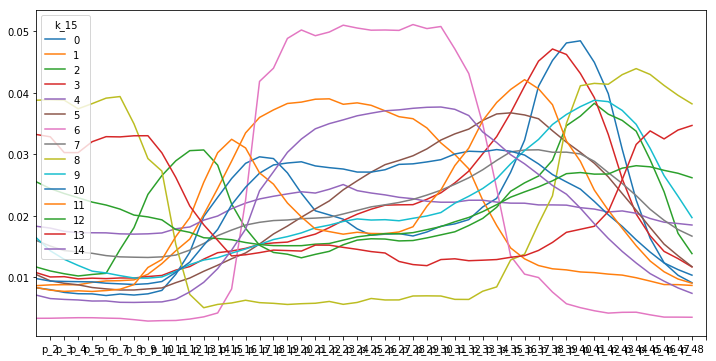

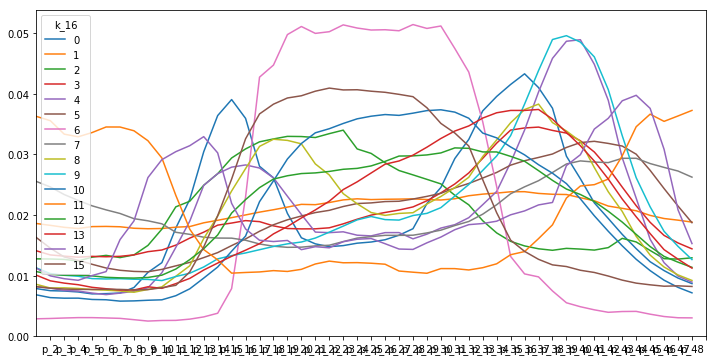

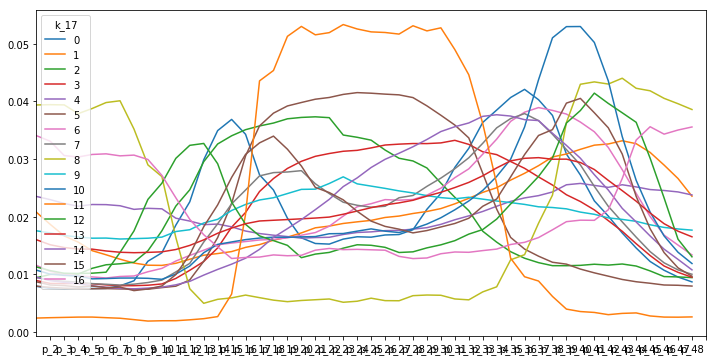

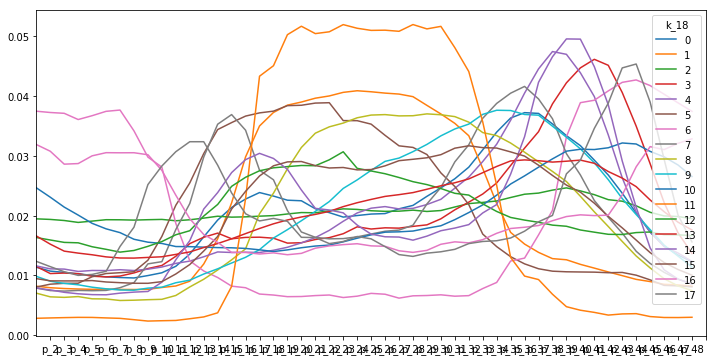

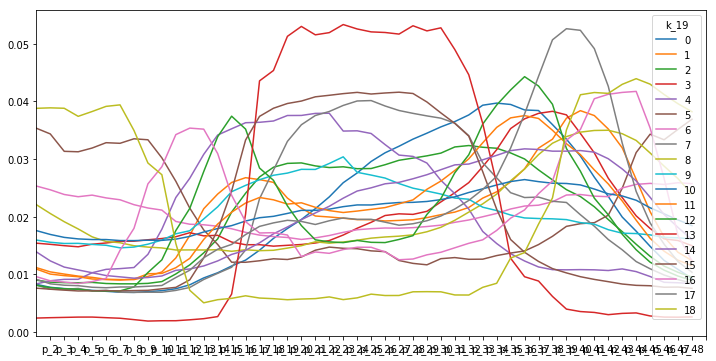

In [30]:
for c, df in centers_and_plot_dfs:
    df.plot(xticks=np.arange(1,49), figsize=(12,6))

In [31]:
count_test = X_train_house.copy()
count_test['Label'] = y_train_house

In [32]:
for k in k_values:
    k_col_name = "k_{}".format(k)
    count_test_percent = count_test.groupby(k_col_name)['Label'].sum()/count_test.groupby(k_col_name)['Label'].count()
    print(k_col_name, (max(count_test_percent) / min(count_test_percent)))

k_2 1.44615384615
k_3 1.50940966011
k_4 1.91980410162
k_5 2.06159122085
k_6 2.5641025641
k_7 3.32229580574
k_8 2.90816326531
k_9 5.06927710843
k_10 2.96527777778
k_11 4.85795454545
k_12 4.440625
k_13 4.55970149254
k_14 4.33333333333
k_15 4.41095890411
k_16 4.73728813559
k_17 7.34693877551
k_18 5.71428571429
k_19 6.96428571429


In [33]:
k_list = np.arange(2,20).tolist()
k_list.remove(9)
columns_to_remove = ["k_{}".format(k) for k in k_list]
X_train_house.drop(columns_to_remove, axis=1, inplace=True)

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
X_train_house.iloc[:, 1:145].head()

,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,u_10,...,p_39,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48
602,0.305867,0.289133,0.275450,0.261250,0.259183,0.291583,0.532667,0.642067,0.711217,0.751017,...,0.035419,0.035223,0.033186,0.030959,0.029389,0.027297,0.016718,0.012797,0.012377,0.011757
483,0.389817,0.371250,0.367267,0.368383,0.366217,0.365183,0.356867,0.359200,0.360800,0.372283,...,0.021195,0.021319,0.021060,0.021830,0.020230,0.019202,0.015799,0.013511,0.011439,0.010201
1286,0.237557,0.192169,0.234931,0.247390,0.181961,0.158980,0.188654,0.261955,0.222893,0.198186,...,0.052245,0.051914,0.053570,0.045476,0.019140,0.014406,0.011500,0.010308,0.008121,0.006240
1009,0.714400,0.696000,0.684533,0.673533,0.646900,0.635050,0.632483,0.598383,0.595467,0.605250,...,0.027063,0.023128,0.025465,0.026261,0.030501,0.032329,0.027500,0.027435,0.029378,0.029757
411,0.316750,0.300883,0.301883,0.294950,0.295750,0.298600,0.290733,0.284767,0.276817,0.341250,...,0.054863,0.053381,0.053078,0.046755,0.038444,0.024479,0.015984,0.010947,0.008577,0.007237


### Apply Predict k-means cluster based on k-nearest neighbors

In [35]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_house.iloc[:, 1:145], X_train_house.iloc[:,145]) 
X_valid_house['k_9'] = neigh.predict(X_valid_house.iloc[:, 1:145])

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### House Prediction

In [36]:
h_clf1 = GradientBoostingClassifier(random_state = 42)
h_clf1.fit(X_train_house, y_train_house)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [37]:
h_clf1.feature_importances_

array([  3.32508506e-02,   6.75851785e-03,   1.55058516e-03,
         4.49561581e-03,   0.00000000e+00,   8.37088775e-04,
         4.26933767e-03,   1.20950147e-02,   4.53612124e-03,
         1.60223769e-03,   1.25098436e-03,   1.69252199e-03,
         5.67935262e-03,   1.04498118e-02,   1.10345605e-03,
         1.11232808e-03,   3.90702881e-03,   0.00000000e+00,
         5.85550447e-03,   1.30568497e-03,   0.00000000e+00,
         0.00000000e+00,   2.10491925e-03,   0.00000000e+00,
         8.58752835e-04,   1.08610718e-03,   3.68667717e-04,
         0.00000000e+00,   4.35447799e-03,   0.00000000e+00,
         2.15627292e-03,   3.22026003e-03,   3.66331176e-03,
         8.19043299e-03,   1.61213174e-02,   1.51858009e-02,
         4.33353087e-03,   1.36918682e-03,   1.44491597e-03,
         0.00000000e+00,   3.00234400e-03,   4.51188290e-03,
         9.23129965e-05,   4.13361711e-03,   2.11628736e-03,
         2.98223456e-03,   5.30907747e-03,   4.09614921e-03,
         0.00000000e+00,

In [38]:
y_train_house_pred = h_clf1.predict(X_train_house)

In [39]:
f1_score(y_train_house, y_train_house_pred)

0.98145506419400852

In [40]:
confusion_matrix(y_train_house, y_train_house_pred)

array([[835,   0],
       [ 13, 344]])

In [41]:
y_valid_house_pred = h_clf1.predict(X_valid_house)

In [42]:
f1_score(y_valid_house, y_valid_house_pred)

0.75303643724696356

In [43]:
confusion_matrix(y_valid_house, y_valid_house_pred)

array([[244,  26],
       [ 35,  93]])

# Time Classification

In [44]:
ev_train_piv_lab_tmp_filled_tmp_transformed = ev_train_piv_lab_tmp_filled.copy()

In [45]:
print(y_train_house.sum())
print(y_valid_house_pred.sum())

357
119


In [46]:
h_time_train = X_train_house['House ID'][y_train_house>0].values
h_time_valid = X_valid_house['House ID'][y_valid_house_pred>0].values

In [47]:
X_train_bool = ev_train_piv_lab_tmp_filled_tmp_transformed['House ID'].isin(h_time_train)
X_valid_bool = ev_train_piv_lab_tmp_filled_tmp_transformed['House ID'].isin(h_time_valid)

In [48]:
X_train_time = ev_train_piv_lab_tmp_filled_tmp_transformed[X_train_bool]
y_train_time = X_train_time['Label']
X_train_time.drop(['Label'], axis=1, inplace=True)
display(X_train_time.head())
display(y_train_time.head())

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,House ID,Day,Hour,Half Hour,Interval,kWh
2880,11628291,1,1,1,1,0.728
2881,11628291,1,1,2,2,0.742
2882,11628291,1,2,3,3,0.749
2883,11628291,1,2,4,4,0.749
2884,11628291,1,3,5,5,0.743


2880    0
2881    0
2882    0
2883    0
2884    0
Name: Label, dtype: int64

In [49]:
X_valid_time = ev_train_piv_lab_tmp_filled_tmp_transformed[X_valid_bool]
y_valid_time = X_valid_time['Label']
X_valid_time.drop(['Label'], axis=1, inplace=True)
display(X_valid_time.head())
display(y_valid_time.head())

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,House ID,Day,Hour,Half Hour,Interval,kWh
66240,11628565,1,1,1,1,0.341
66241,11628565,1,1,2,2,0.324
66242,11628565,1,2,3,3,0.292
66243,11628565,1,2,4,4,0.161
66244,11628565,1,3,5,5,0.127


66240    0
66241    0
66242    0
66243    0
66244    0
Name: Label, dtype: int64

In [50]:
print(X_train_time.shape[0]/2880)
print(X_valid_time.shape[0]/2880)

357.0
119.0


### Augment Training Data

In [51]:
c9, df9 = centers_and_plot_dfs[7]

In [52]:
display(pd.DataFrame(c9).T.head())
display(df9.head())
centers_df = pd.DataFrame(c9).T.reset_index()
centers_df.columns = ['Half Hour']+["c{}".format(k) for k in np.arange(1,10).tolist()]
centers_df['Half Hour'] = centers_df['Half Hour']+1

,0,1,2,3,4,5,6,7,8
0,0.008584,0.008867,0.017858,0.021708,0.008976,0.013869,0.034947,0.003850,0.009806
1,0.008268,0.008919,0.017487,0.020474,0.008513,0.012574,0.034425,0.003908,0.009190
2,0.008088,0.008912,0.017145,0.019261,0.008400,0.011895,0.032575,0.003906,0.008960
3,0.008016,0.008812,0.016887,0.018477,0.008363,0.011596,0.032162,0.003915,0.008753
4,0.007891,0.009136,0.016951,0.017906,0.008192,0.011417,0.032212,0.003896,0.008464


k_9,0,1,2,3,4,5,6,7,8
p_1,0.008584,0.008867,0.017858,0.021708,0.008976,0.013869,0.034947,0.003850,0.009806
p_2,0.008268,0.008919,0.017487,0.020474,0.008513,0.012574,0.034425,0.003908,0.009190
p_3,0.008088,0.008912,0.017145,0.019261,0.008400,0.011895,0.032575,0.003906,0.008960
p_4,0.008016,0.008812,0.016887,0.018477,0.008363,0.011596,0.032162,0.003915,0.008753
p_5,0.007891,0.009136,0.016951,0.017906,0.008192,0.011417,0.032212,0.003896,0.008464


In [53]:
X_train_time_augmented = augment_time_data(
    X_train_time, 
    X_train_house, 
    centers_df)

### Predict Training Data

In [54]:
t_clf1 = GradientBoostingClassifier(random_state = 42)
t_clf1.fit(X_train_time_augmented, y_train_time)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [55]:
y_train_time_pred = t_clf1.predict(X_train_time_augmented)

In [56]:
f1_score(y_train_time, y_train_time_pred)

0.72386198145718295

In [57]:
confusion_matrix(y_train_time, y_train_time_pred)

array([[939656,  10789],
       [ 27513,  50202]])

### Augment Validation Data

In [58]:
X_valid_time_augmented = augment_time_data(
    X_valid_time, 
    X_valid_house, 
    centers_df)

### Predict Validation Training Data

In [59]:
show_baseline_f1_scores(y_valid_time)

All 0 F-score: 0.000
Alternating 0,1 F-score: 0.110
All 1 F-score: 0.116


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
y_valid_time_pred = t_clf1.predict(X_valid_time_augmented)

In [61]:
f1_score(y_valid_time, y_valid_time_pred)

0.67729655964950086

In [62]:
confusion_matrix(y_valid_time, y_valid_time_pred)

array([[315096,   6502],
       [  6977,  14145]])

### Transform Back to Raw Format

In [63]:
EV_train_label_predictions = format_EV_predictions(
    y_valid_time_pred, 
    X_valid_time_augmented
)

In [64]:
EV_train_label_predictions.head()

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
House ID,,,,,,,,,,,,,,,,,,,,,
11628565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11628886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11628910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11629322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11629366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
